In [1]:
import glob

%matplotlib inline
import mne
import numpy as np
import pandas as pd
import scipy.io
import seaborn as sns

# Figures inline and set visualization style
sns.set()
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.fftpack import fft, fftfreq, ifft, irfft, rfft
from scipy.integrate import simps
from scipy.signal import butter, filtfilt, hilbert

warnings.filterwarnings("ignore")

In [2]:
# read the excel files just in case 
patients_256 = pd.read_excel("/Users/elifozkan/Desktop/EEG-Burst-Suppression-Analysis/3-June2022 /Alle_patienten_256Hz.xlsx")
patients_250 = pd.read_excel("/Users/elifozkan/Desktop/EEG-Burst-Suppression-Analysis/3-June2022 /Alle_patienten_250Hz.xlsx")

In [3]:
patients_250 = patients_250.rename(columns = {"Burstsupressie (ja/nee)" : "BS",
                                                "Nummer" : "ID"})
patients_250 = patients_250.dropna(subset = ["ID"])
patients_250 = patients_250.astype({"ID" : int})
patients_250_ids = list(patients_250["ID"])

In [4]:
patients_256 = patients_256.rename(columns = {"Burstsupressie (ja/nee)" : "BS",
                                                "Nummer" : "ID"})
patients_256 = patients_256.dropna(subset = ["ID"])
patients_256 = patients_256.astype({"ID" : int})
patients_256_ids = list(patients_256["ID"])
#patients_df = pd.concat([patients_data, patients_data1])
#patients_df = patients_df.drop(["file code"], axis = 1)

In [5]:
patients = glob.glob("/Users/elifozkan/Desktop/EEG-Burst-Suppression-Analysis/3-June2022 /*.mat")
patient_files_250 = []
patient_files_256 = []

for i in range(0,len(patients)): 
    temp = patients[i].replace("/Users/elifozkan/Desktop/EEG-Burst-Suppression-Analysis/3-June2022 /patient_","")
    temp = int(temp.replace(".mat", ""))
    if temp in patients_250_ids:
        patient_files_250.append(patients[i])
    else:
        patient_files_256.append(patients[i])
    

In [6]:
# necessary information taken from the data in order to create MNE objects. 
channelLabels = ["Fp1", "Fp2", "F7", "F3", "Fz", "F4", "F8",
                "A1", "T3", "C3", "Cz", "C4", "T4", "A2", "T5", 
                "P3", "Pz", "P4", 'T6', '01', '02', 'ECG']
trials = 1 
n_channels = 22
ch_types = ['eeg'] * (n_channels-3)
ch_types.append('misc')
ch_types.append('misc')
ch_types.append('ecg')

In [7]:
def define_montage(type):
    '''method that helps us define the channel locations '''

    # Form the 10-20 montage 'standard_1020'
    mont1020 = mne.channels.make_standard_montage(type)
    # Choose what channels you want to keep 
    # Make sure that these channels exist e.g. T1 does not exist in the standard 10-20 EEG system!
    kept_channels = ["Fp1", "Fp2", "F7", "F3", "Fz", "F4", "F8",
                "A1", "T3", "C3", "Cz", "C4", "T4", "A2", "T5", 
                "P3", "Pz", "P4", 'T6']
    ind = [i for (i, channel) in enumerate(mont1020.ch_names) if channel in kept_channels]
    mont1020_new = mont1020.copy()
    # Keep only the desired channels
    mont1020_new.ch_names = [mont1020.ch_names[x] for x in ind]
    kept_channel_info = [mont1020.dig[x+3] for x in ind]
    # Keep the first three rows as they are the fiducial points information
    mont1020_new.dig = mont1020.dig[0:3]+kept_channel_info
    
    #mont1020.plot()
    #mont1020_new.plot()
    
    return mont1020_new

In [8]:
def create_MNE_objects(patient_list,channelLabels,n_channels,sampling_frequency,phase,types): 
    evoked_arrays = []
    for i in range(0,len(patient_list)): 
        patient = scipy.io.loadmat(patient_list[i])
        samples = patient[phase]["data"][0][0]
        
        info = mne.create_info(
        ch_names = channelLabels, 
        ch_types = types,
        sfreq = sampling_frequency)
        
        info.set_montage(define_montage('standard_1020'))
        evoked_array = mne.EvokedArray(samples, info,
                               nave=samples.shape[0], comment=('patient' + str(i)))
        evoked_arrays.append(evoked_array)
    return evoked_arrays

In [9]:
def create_Raw_objects(patient_list,channelLabels,n_channels,sampling_frequency,phase,types,ids):
    evoked_arrays = {}
    for i in range(0,len(patient_list)): 
        patient = scipy.io.loadmat(patient_list[i])
        samples = patient[phase]["data"][0][0]
        
        info = mne.create_info(
        ch_names = channelLabels, 
        ch_types = types,
        sfreq = sampling_frequency)
        
        info.set_montage(define_montage('standard_1020'))
        evoked_array = mne.io.RawArray(samples, info)
        evoked_arrays.update({ids[i] : evoked_array })
    return evoked_arrays

In [10]:
eeg_InDia_250 = create_Raw_objects(patient_files_250, channelLabels, n_channels, 250,"EEG_INDIA",ch_types,patients_250_ids);
eeg_InDia_256 = create_Raw_objects(patient_files_256,channelLabels, n_channels, 256, "EEG_INDIA", ch_types,patients_256_ids);
#eeg_PreOK = create_MNE_objects(patients, channelLabels, n_channels, sampling_frequency, "EEG_PreOK",ch_types)
#eeg_Klem = create_MNE_objects(patients, channelLabels, n_channels, sampling_frequency, "EEG_Klem",ch_types)

Creating RawArray with float64 data, n_channels=22, n_times=0
    Range : 0 ... -1 =      0.000 ...    -0.004 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=391128
    Range : 0 ... 391127 =      0.000 ...  1564.508 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=169409
    Range : 0 ... 169408 =      0.000 ...   677.632 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=291251
    Range : 0 ... 291250 =      0.000 ...  1165.000 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=162501
    Range : 0 ... 162500 =      0.000 ...   650.000 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=152051
    Range : 0 ... 152050 =      0.000 ...   608.200 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=369993
    Range : 0 ... 369992 =      0.000 ...  1479.968 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=501
    Range : 0 ... 500 =     

In [11]:
def remove_zero_times(raw_array,patient_ids) : 
    res = raw_array.copy() 
    for i in raw_array: 
        if raw_array[i].n_times == 0 or raw_array[i].n_times == 1:
            del res[i]
            patient_ids.remove(i)
    
    return res,patient_ids

In [12]:
eeg_india_250, patients_250_ids= remove_zero_times(eeg_InDia_250,patients_250_ids)
eeg_india_256, patients_256_ids = remove_zero_times(eeg_InDia_256,patients_256_ids)


In [13]:
eeg_india = {}
eeg_india.update(eeg_india_250)
eeg_india.update(eeg_india_256)


## Time Domain Features 

In [14]:
## extract time-domain features 

def calculate_mean(raw_array, patient_ids):
    mean_dict = {}
    for i in patient_ids: 

        col_mean = raw_array[i].get_data().mean(axis = 1)
        mean = col_mean.mean()

        mean_dict.update({i : mean})
    return mean_dict


def standard_deviation(raw_array, patient_ids): 
    std_dict = {}
    for i in patient_ids: 

        col_std = raw_array[i].get_data().std(axis = 1)
        std = col_std.std()

        std_dict.update({i : std})
    return std_dict

## Frequency Domain Transformation and Features

 -  delta (0.5–4 Hz)
  - theta (4–8 Hz)  
 -  alpha (8–12 Hz)
 -  beta (12–30 Hz)
 -  gamma (30–100 Hz)

In [15]:
def bandpower(data, sf, band, window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.
        Absolute or relative band power.
    """
    from scipy.integrate import simps
    from scipy.signal import welch
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)
    # Frequency resolution
    freq_res = freqs[1] - freqs[0]
    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

def average_band_power(band, eeg_array,relative = False,window_size = 2):
    mean_bps = []
    for i in eeg_array: 
        bps = []
        for j in range(0,22): 
            bp = bandpower(eeg_array[i].get_data()[j],250,band, window_size, relative = relative)
            bps.append(bp) 
        mean  = np.mean(bps)
        mean_bps.append(mean)
    return mean_bps

In [16]:
mean_power_delta = average_band_power([0.5,3],eeg_india,window_size=2)
mean_power_theta = average_band_power([4,7],eeg_india, window_size= 2)
mean_power_alpha = average_band_power([8,11],eeg_india, window_size= 2)
mean_power_beta = average_band_power([12,29],eeg_india, window_size= 2)
mean_power_gamma = average_band_power([30,50],eeg_india, window_size= 2)

In [17]:
mean_rel_power_delta = average_band_power([0.5,3],eeg_india,relative = True,window_size=2)
mean_rel_power_theta = average_band_power([4,7],eeg_india,relative = True,window_size=2)
mean_rel_power_alpha = average_band_power([8,11],eeg_india,relative = True,window_size=2)
mean_rel_power_beta = average_band_power([12,29],eeg_india,relative = True,window_size=2)
mean_rel_power_gamma = average_band_power([30,50],eeg_india,relative = True,window_size=2)

In [18]:
def find_ratio(band1, band2): 
    ratio_array = []
    for i in range (0,len(band1)): 
        ratio = 1 / (band1[i] / band2[i])
        ratio_array.append(ratio)
    return ratio_array

In [19]:
delta_alpha = find_ratio(mean_power_delta,mean_power_alpha)
delta_beta = find_ratio(mean_power_delta,mean_power_beta)
delta_theta = find_ratio(mean_power_delta,mean_power_theta)
delta_gamma = find_ratio(mean_power_delta,mean_power_gamma)

alpha_beta = find_ratio(mean_power_alpha,mean_power_beta)
alpha_theta = find_ratio(mean_power_alpha,mean_power_theta)
alpha_gamma = find_ratio(mean_power_alpha, mean_power_gamma)

beta_theta = find_ratio(mean_power_beta,mean_power_theta)
beta_gamma = find_ratio(mean_power_beta,mean_power_gamma)

theta_gamma = find_ratio(mean_power_theta,mean_power_gamma)


In [20]:
def calc_shannon_entropy(data_set):
    entropies = []
    for i in data_set: 
        probability = np.square(data_set[i].get_data())
        shannon_entropy = -np.nansum(probability * np.log2(probability))
        entropies.append(round(shannon_entropy, 3))
    return entropies

In [21]:
shannon_entropy = calc_shannon_entropy(eeg_india)

In [22]:
ids = patients_250_ids+ patients_256_ids
power_df = pd.DataFrame({"ID" : ids, 
                        "mean_alpha" : mean_power_alpha,
                        "mean_beta" : mean_power_beta, 
                        "mean_delta" : mean_power_delta, 
                        "mean_theta" : mean_power_theta, 
                        "mean_gamma" : mean_power_gamma,
                        "mean_rel_alpha" : mean_rel_power_alpha, 
                        "mean_rel_power_beta" : mean_rel_power_beta, 
                        "mean_rel_delta" : mean_rel_power_delta, 
                        "mean_rel_theta" : mean_rel_power_theta, 
                        "mean_rel_gamma" : mean_rel_power_gamma,
                        "delta_alpha" : delta_alpha,
                        "delta_beta" : delta_beta,
                        "delta_theta" : delta_theta, 
                        "delta_gamma" : delta_gamma, 
                        "alpha_beta" : alpha_beta, 
                        "alpha_theta" : alpha_theta, 
                        "alpha_gamma": alpha_gamma, 
                        "beta_theta" : beta_theta,
                        "beta_gamma" : beta_gamma,
                        "theta_gamma" : theta_gamma,
                        "shannon_entropy" : shannon_entropy})
power_df



,ID,mean_alpha,mean_beta,mean_delta,mean_theta,mean_gamma,mean_rel_alpha,mean_rel_power_beta,mean_rel_delta,mean_rel_theta,...,delta_beta,delta_theta,delta_gamma,alpha_beta,alpha_theta,alpha_gamma,beta_theta,beta_gamma,theta_gamma,shannon_entropy
0,2,766.213723,1332.381019,13780.120189,1800.035440,345.862682,0.026136,0.043020,0.576028,0.067843,...,0.096689,0.130626,0.025099,1.738916,2.349260,0.451392,1.350992,0.259582,0.192142,-4.532263e+12
1,3,86.829847,127.940888,297.671128,95.000688,7.812570,0.103331,0.081328,0.428305,0.059509,...,0.429806,0.319146,0.026246,1.473467,1.094102,0.089976,0.742536,0.061064,0.082237,-4.993946e+10
2,4,161.380048,235.686257,3333.970099,473.973795,19.957135,0.042729,0.020356,0.533540,0.050145,...,0.070692,0.142165,0.005986,1.460442,2.937004,0.123665,2.011037,0.084677,0.042106,-7.839311e+11
3,5,138.799199,154.997477,685.474977,390.998705,9.673576,0.045963,0.057864,0.524138,0.097003,...,0.226117,0.570406,0.014112,1.116703,2.817010,0.069695,2.522613,0.062411,0.024741,-1.176841e+11
4,6,927.650638,1129.216180,7714.776172,2625.624490,208.352370,0.060089,0.041034,0.518468,0.052514,...,0.146371,0.340337,0.027007,1.217286,2.830402,0.224602,2.325174,0.184511,0.079353,-1.180955e+12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,373,170.464304,264.512273,1276.486901,347.682846,24.115642,0.020135,0.025423,0.519971,0.070390,...,0.207219,0.272375,0.018892,1.551717,2.039623,0.141470,1.314430,0.091170,0.069361,-4.612504e+11
244,375,70.474037,222.174156,614.720466,95.709151,24.830918,0.016599,0.056736,0.508499,0.026459,...,0.361423,0.155695,0.040394,3.152567,1.358077,0.352341,0.430784,0.111763,0.259441,-4.185492e+10
245,376,19106.162263,95097.960813,12875.782217,24624.710100,67268.210258,0.085061,0.415048,0.057935,0.109986,...,7.385801,1.912483,5.224398,4.977345,1.288836,3.520760,0.258940,0.707357,2.731736,-4.427380e+12
246,377,60.307137,71.235876,385.423770,152.743360,3.976432,0.148868,0.100241,0.409870,0.043182,...,0.184825,0.396300,0.010317,1.181218,2.532758,0.065936,2.144192,0.055821,0.026033,-9.307036e+09


In [23]:
def plot_spectrum_methods(data, sf, window_sec, band=None, dB=False):

    import matplotlib.pyplot as plt
    from mne.time_frequency import psd_array_multitaper
    from scipy.signal import periodogram, welch
    sns.set(style="white", font_scale=1.2)
    # Compute the PSD
    freqs, psd = periodogram(data, sf)
    freqs_welch, psd_welch = welch(data, sf, nperseg=window_sec*sf)
    psd_mt, freqs_mt = psd_array_multitaper(data, sf, adaptive=True,
                                            normalization='full', verbose=0)
    sharey = False

    # Optional: convert power to decibels (dB = 10 * log10(power))
    if dB:
        psd = 10 * np.log10(psd)
        psd_welch = 10 * np.log10(psd_welch)
        psd_mt = 10 * np.log10(psd_mt)
        sharey = True

    # Start plot
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=sharey)
    # Stem
    sc = 'slategrey'
    ax2.stem(freqs, psd, linefmt=sc, basefmt=" ", markerfmt=" ")
    ax1.stem(freqs_welch, psd_welch, linefmt=sc, basefmt=" ", markerfmt=" ")
    ax3.stem(freqs_mt, psd_mt, linefmt=sc, basefmt=" ", markerfmt=" ")
    # Line
    lc, lw = 'k', 2
    ax2.plot(freqs, psd, lw=lw, color=lc)
    ax1.plot(freqs_welch, psd_welch, lw=lw, color=lc)
    ax3.plot(freqs_mt, psd_mt, lw=lw, color=lc)
    # Labels and axes
    ax1.set_xlabel('Frequency (Hz)')
    if not dB:
        ax1.set_ylabel('Power spectral density (V^2/Hz)')
    else:
        ax1.set_ylabel('Decibels (dB / Hz)')
    ax2.set_title('Periodogram')
    ax1.set_title('Mean-power Alpha Band')
    ax3.set_title('Multitaper')
    if band is not None:
        ax1.set_xlim(band)
    ax1.set_ylim(ymin=0)
    ax2.set_ylim(ymin=0)
    ax3.set_ylim(ymin=0)
    sns.despine()


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished


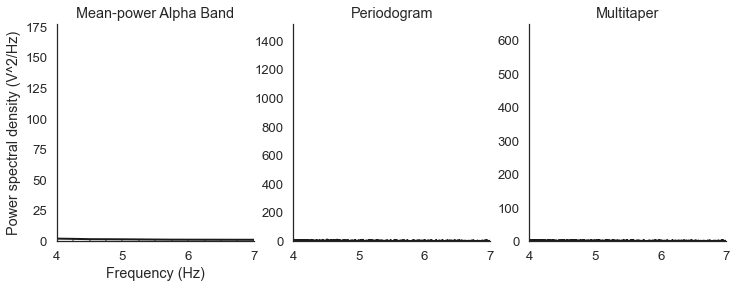

In [24]:
plot_spectrum_methods(eeg_india[16].get_data()[2], 250, 4, band=[4,7], dB=False)

NOTE: plot_psd_topo() is a legacy function. New code should use .compute_psd().plot_topo().
Effective window size : 1.024 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


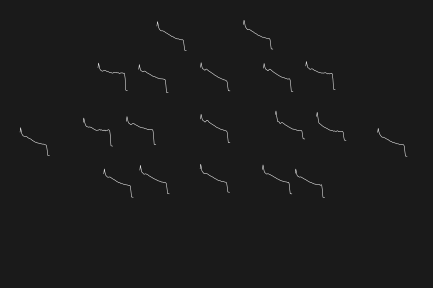

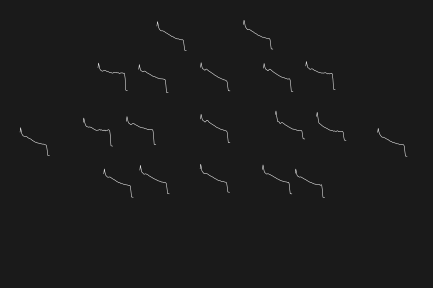

In [25]:
eeg_india[16].plot_psd_topo(fmax = 50)


Effective window size : 1.024 (s)


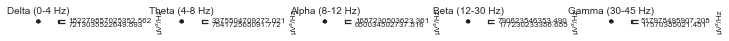

In [26]:
eeg_india[16].compute_psd().plot_topomap();

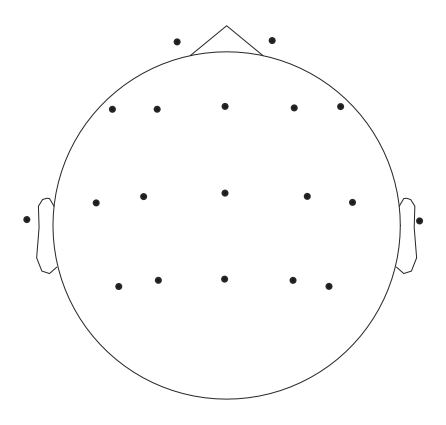

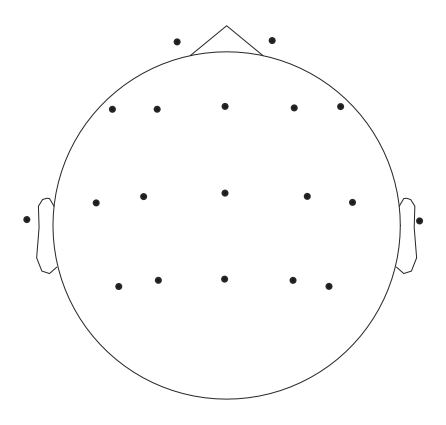

In [27]:
eeg_india[16].plot_sensors(ch_type = "eeg")

In [28]:
patients_df = patients_250.append(patients_256,ignore_index=True)
patients_df = patients_df[patients_df["ID"].isin(ids)]
patients_df = pd.merge(patients_df,power_df, on = "ID")
patients_df.drop(["Tijdstip ogen dicht", "Tijdstip ogen open", "tijdstip tweede ogen dicht", "tijdstip tweede ogen open", 
                   "tijdstip derde ogen dicht","tijdstip derde ogen open", "Tijdstip start op OK","Tijdstip start inleiding",'Tijdstip start diathermie', 'Tijdstip start klem', 'Duur klem',
       'Tijdstip einde OK', 'file code','opm'], inplace=True, axis=1)
patients_df["BS"] = patients_df["BS"].map({'ja' : 1, 'nee' : 0})

In [116]:
additional = pd.read_excel("/Users/elifozkan/Desktop/EEG-Burst-Suppression-Analysis/3-June2022 /additional_data.xlsx")
additional = additional.rename(columns={"Subject_no" : "ID"})
additional= additional[additional["ID"].isin(ids)]
final_df = pd.merge(patients_df,additional, on = "ID")
final_df

,ID,BS,Age at OR,mean_alpha,mean_beta,mean_delta,mean_theta,mean_gamma,mean_rel_alpha,mean_rel_power_beta,...,RRdiastolic3minutesafterclampingmmHg,RRdiastolicrightafterclampreleasemmHg,RRdiastolic1minuteafterclampreleasemmHg,RRdiastolic3minutesafterclampreleasemmHg,RRdiastolicendofORmmHg,meanmicroembolismduringOR≈,summicroembolismduringOR,meanmicroembolismafterOR≈,summicroembolismafterendofOR,interventionbecauseofMES
0,2,NaN,78.168378,766.213723,1332.381019,13780.120189,1800.035440,345.862682,0.026136,0.043020,...,81.0,77.0,78.0,78.0,0.0,NaN,22,0,0,0.0
1,3,NaN,69.295003,86.829847,127.940888,297.671128,95.000688,7.812570,0.103331,0.081328,...,67.0,42.0,39.0,39.0,44.0,"0,04/ min",3,"0,07/ min",4,0.0
2,4,NaN,71.107461,161.380048,235.686257,3333.970099,473.973795,19.957135,0.042729,0.020356,...,74.0,79.0,73.0,67.0,0.0,NaN,7,0,0,0.0
3,5,NaN,74.759754,138.799199,154.997477,685.474977,390.998705,9.673576,0.045963,0.057864,...,0.0,65.0,62.0,60.0,55.0,0,0,0,0,0.0
4,6,NaN,78.954141,927.650638,1129.216180,7714.776172,2625.624490,208.352370,0.060089,0.041034,...,103.0,0.0,0.0,85.0,100.0,0,0,#,#,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,373,0.0,79.362081,170.464304,264.512273,1276.486901,347.682846,24.115642,0.020135,0.025423,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
244,375,1.0,69.804244,70.474037,222.174156,614.720466,95.709151,24.830918,0.016599,0.056736,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,376,0.0,75.707050,19106.162263,95097.960813,12875.782217,24624.710100,67268.210258,0.085061,0.415048,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,377,1.0,69.253936,60.307137,71.235876,385.423770,152.743360,3.976432,0.148868,0.100241,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
# for c in categorical_vars:
#     final_df.boxplot(c, by = "BS", figsize=(7,4))
#     plt.title("{}\n".format(c))
#     plt.xlabel("Burst Supression")



In [117]:
def remove_uninformative_features(df): 
    uninformative_features = []
    for i in df.columns: 
        if (i != "BS") & (df[i].isna().sum() >= 35): 
            uninformative_features.append(i)
    new_df = df.drop(uninformative_features, axis = 1)
    return new_df

In [118]:
#final_df = final_df.drop(["Dosage_etomidate","Length", "Weight","latencyofclampingtoEEGchangesminutes",
             #"Age at OR","Hypertension_tom", "kindofcomplication1","Antihypertensiva_recovery" ],axis = 1)
final_df = remove_uninformative_features(final_df)
final_df.columns


Index(['ID', 'BS', 'Age at OR', 'mean_alpha', 'mean_beta', 'mean_delta',
       'mean_theta', 'mean_gamma', 'mean_rel_alpha', 'mean_rel_power_beta',
       'mean_rel_delta', 'mean_rel_theta', 'mean_rel_gamma', 'delta_alpha',
       'delta_beta', 'delta_theta', 'delta_gamma', 'alpha_beta', 'alpha_theta',
       'alpha_gamma', 'beta_theta', 'beta_gamma', 'theta_gamma',
       'shannon_entropy', 'Gender', 'Age_OR', 'Smoking', 'hypertension',
       'diabetes', 'obesity', 'dyslipidaemia', 'coronar_artery_disease', 'PAD',
       'symptomatic_stenosis', 'Kind_of_symptomatic_TIAstroke',
       'localisation_of_operation', 'type_of_operation',
       'contralateral_stenosis', 'degree_of_contralateral_stenosis_NASCET',
       'clamping_time_min', 'shunting', 'shunt_indication', 'complication',
       'kindofcomplication1', 'EEGchanges',
       'latencyofclampingtoEEGchangesminutes', 'TIA', 'Stroke', 'MI',
       'Nervedamage', 'postopbleedingIntracranicalHemorrhage', 'Deathin90days',
       'la

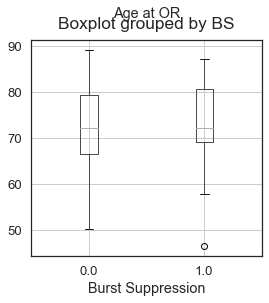

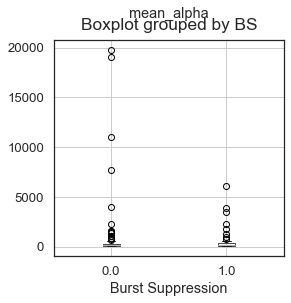

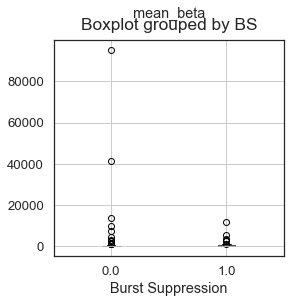

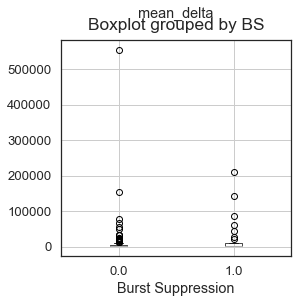

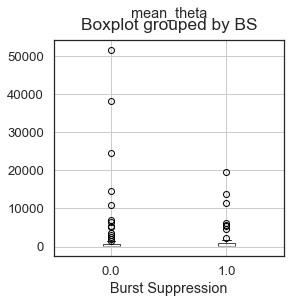

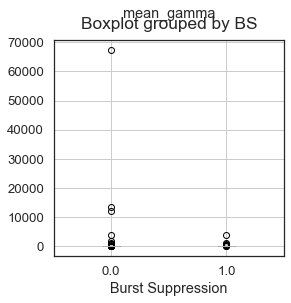

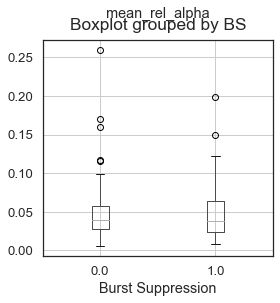

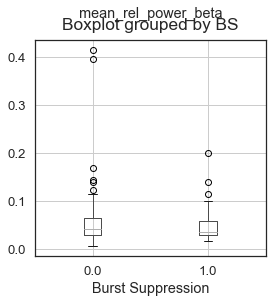

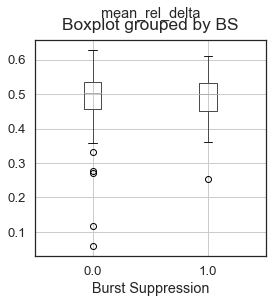

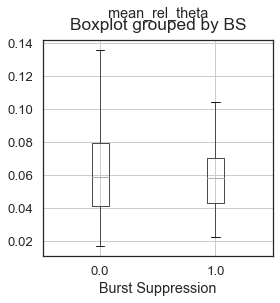

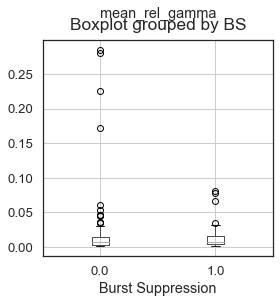

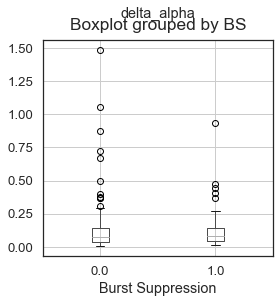

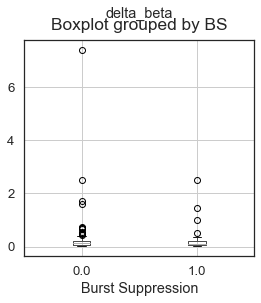

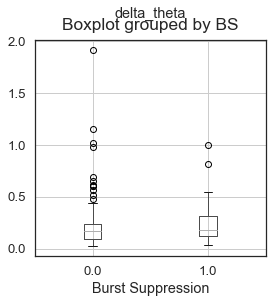

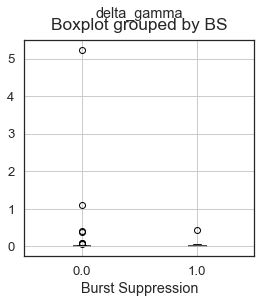

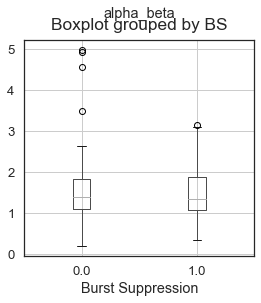

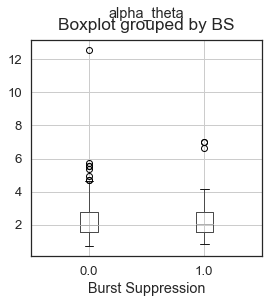

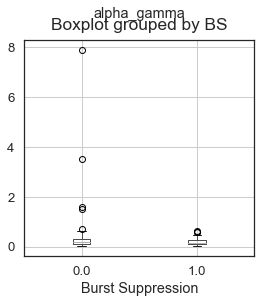

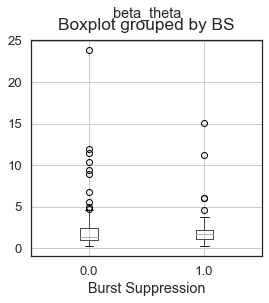

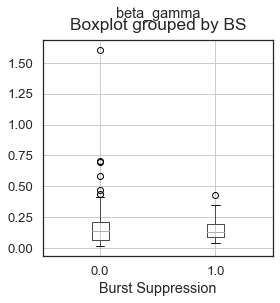

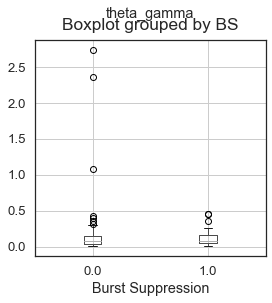

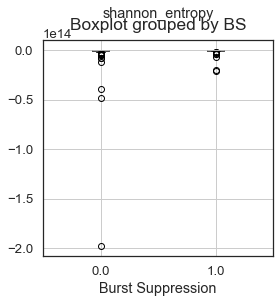

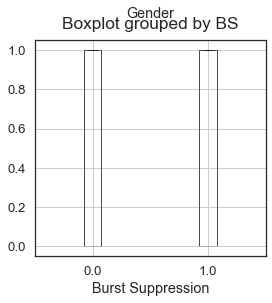

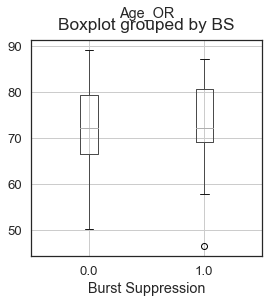

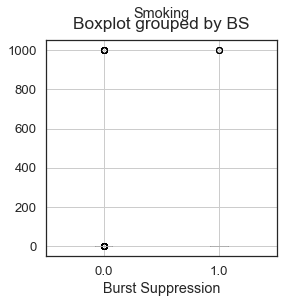

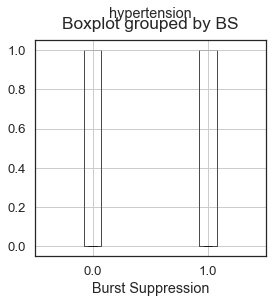

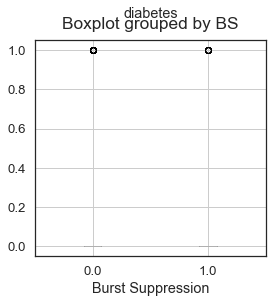

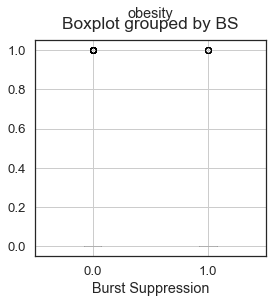

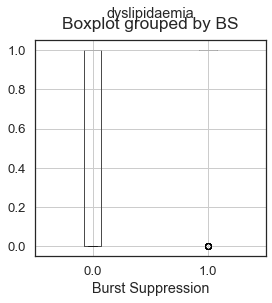

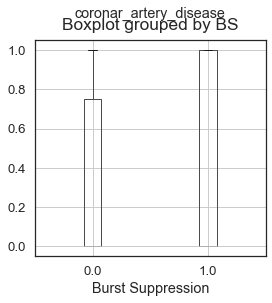

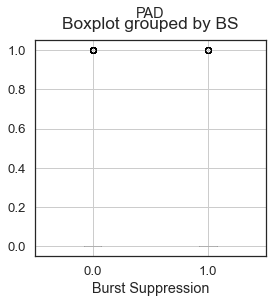

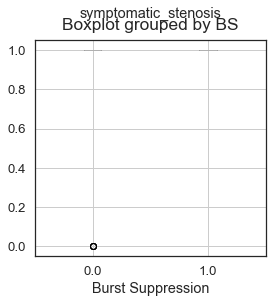

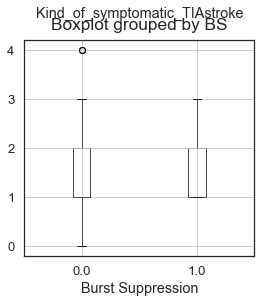

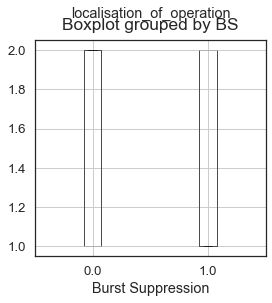

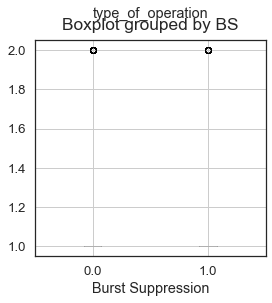

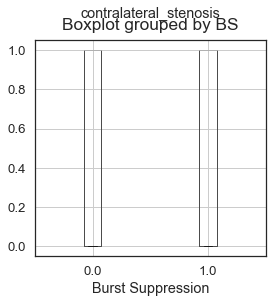

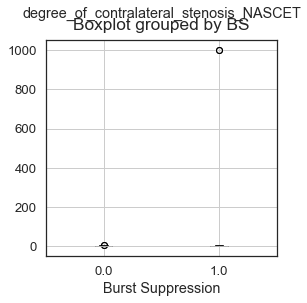

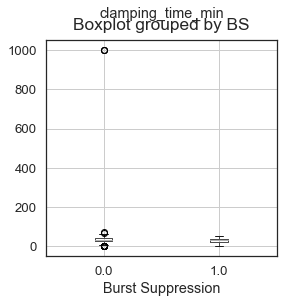

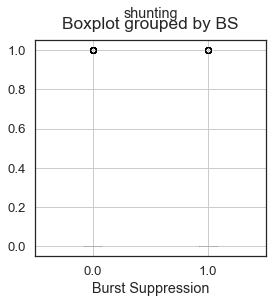

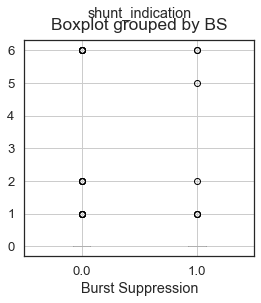

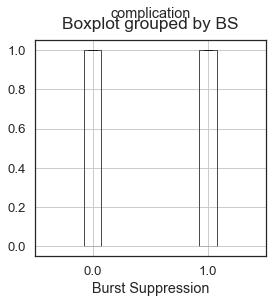

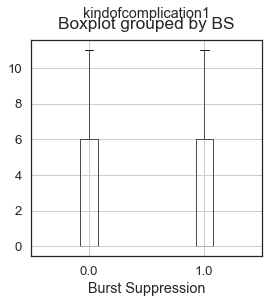

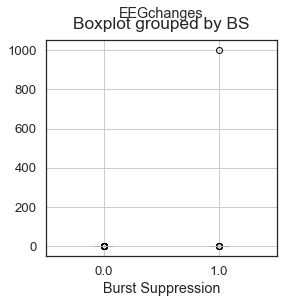

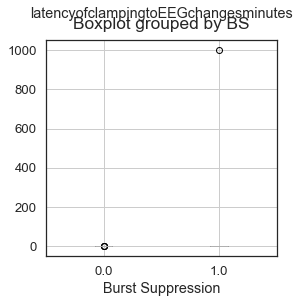

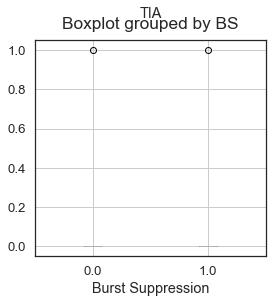

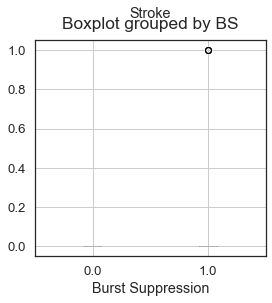

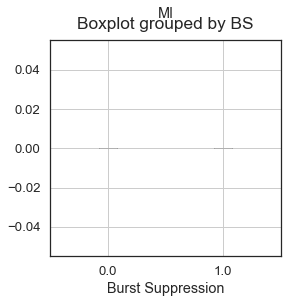

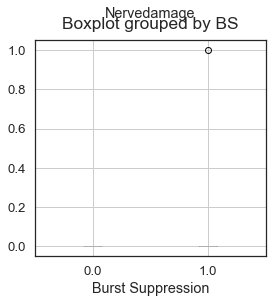

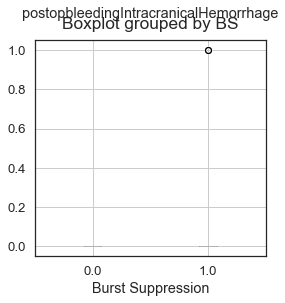

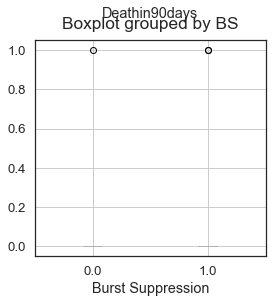

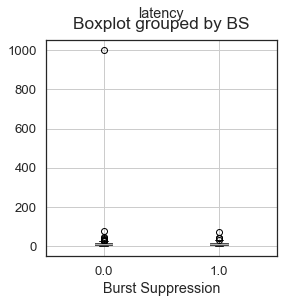

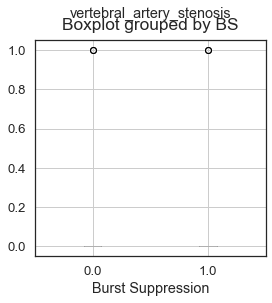

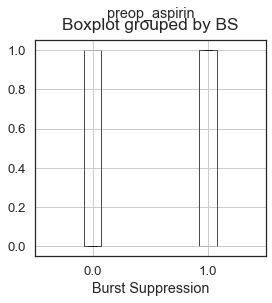

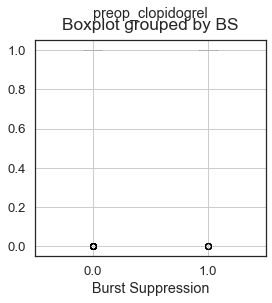

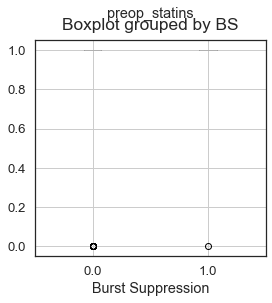

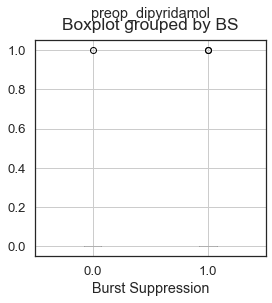

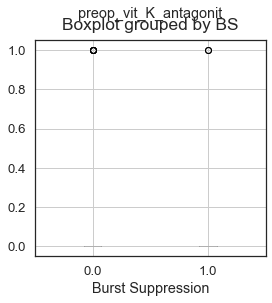

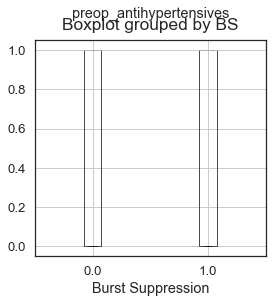

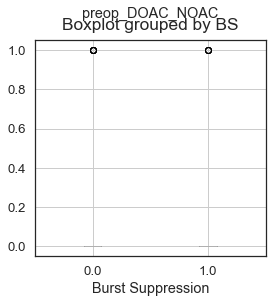

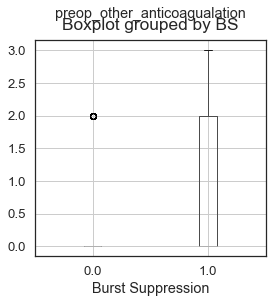

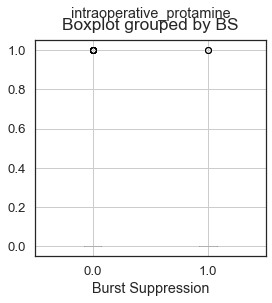

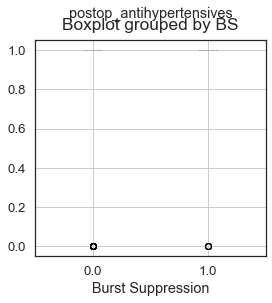

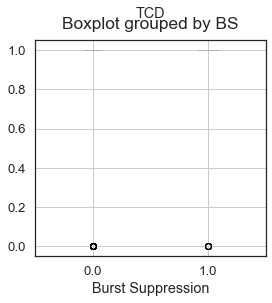

In [119]:
for c in final_df.columns[2:]: 
    final_df.boxplot(c,by = "BS",figsize=(4,4))
    plt.title("{}\n".format(c))
    plt.xlabel("Burst Suppression")

In [112]:
def corrFilter(x: pd.DataFrame, bound: float):
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):

#     print(corrFilter(final_df,0.7))

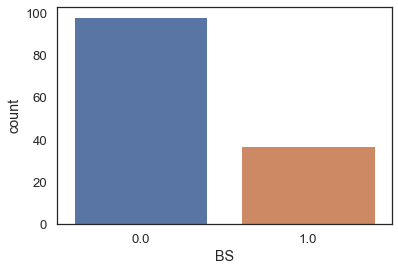

In [30]:
annotated_df  = final_df[final_df["BS"].notna()]
not_annotated_df = final_df[final_df["BS"].isna()]
sns.countplot(x='BS', data=annotated_df);

BS
0.0    AxesSubplot(0.125,0.125;0.775x0.755)
1.0    AxesSubplot(0.125,0.125;0.775x0.755)
Name: mean_beta, dtype: object

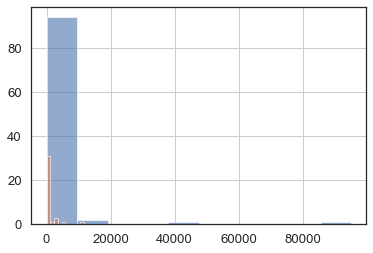

In [31]:
annotated_df.groupby('BS').mean_beta.hist(alpha=0.6)


In [44]:
def remove_uninformative_features(df): 
    uninformative_features = []
    for i in df.columns: 
        if df[i].isna().sum() >= 89: 
            uninformative_features.append(i)
    new_df = df.drop(uninformative_features, axis = 1)
    return new_df


In [71]:
categorical_vars = ["Gender", "At_Risk_Alcohol_consumption","Smoking","hypertension","diabetes",
                    "obesity", "dyslipidaemia","coronar_artery_disease", "Heart_disease_LIBRA",
                      "Kind_of_symptomatic_TIAstroke","Side_stenosis", "localisation_of_operation",
                     "type_of_operation","Symptoms", "contralateral_stenosis", "degree_of_stenosis", "degree_of_contralateral_stenosis_NASCET", 
                     "eGFR", "Induction_propofol", "Induction_etomidate", "Induction_agent_midazolam", "Sufentanil_induction", "Remifentanil_induction",
                      "Induction_fentanyl","Type_of_Anesthesia","Maintenance_opioid", "Maintenance_inhalational", "Vasopression_norepinefrine", "Hypotension_after_induction",
                       "Short_hypotension_after_induction", "Antihypotensive_intraop",
                       "Antihypotensive_use_recovery", "Antihypertensiva_recovery", "shunting", "shunt_indication", "complication","ICUStay", "Periodofmedsgiven","EEGchanges", 
                        "TIA", "Stroke", "MI", "Nervedamage","postopbleedingIntracranicalHemorrhage", "vertebral_artery_stenosis", "preop_aspirin", "preop_clopidogrel",
                    "preop_statins","preop_dipyridamol", "preop_vit_K_antagonit", "preop_antihypertensives","preop_DOAC_NOAC",
                    "preop_other_anticoagualation", "intraoperative_protamine","postop_antihypertensives", "TCD"
                  ]
categorical_vars = annotated_df[categorical_vars]

## Classification 

In [55]:
from numpy import *
from sklearn import metrics, model_selection, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import chi2, SelectKBest 

In [42]:
feature_cols = ['Age at OR', 'mean_alpha', 'mean_beta', 'mean_delta',
       'mean_theta', 'mean_gamma', 'mean_rel_alpha', 'mean_rel_power_beta',
       'mean_rel_delta', 'mean_rel_theta', 'mean_rel_gamma', 'delta_alpha',
       'delta_beta', 'delta_theta', 'delta_gamma', 'alpha_beta', 'alpha_theta',
       'alpha_gamma', 'beta_theta', 'beta_gamma', 'theta_gamma']
X = annotated_df[feature_cols]
y = annotated_df.BS


In [43]:
cross_validation = KFold(n_splits = 10, random_state=1, shuffle=True) # 70% training and 30% test
# Create Decision Tree classifer object
decision_tree = DecisionTreeClassifier(criterion='entropy',max_depth=5)
decision_tree.fit(X, y)
decision_tree_scores = cross_val_score(decision_tree, X, y, scoring="recall", cv = cross_validation, n_jobs=-1)
print('Precision: %.3f (%.3f)' % (mean(decision_tree_scores), std(decision_tree_scores)))


Precision: 0.264 (0.317)


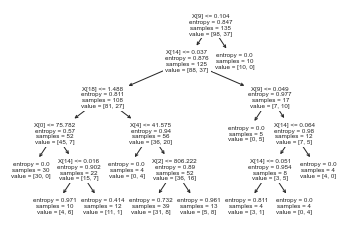

In [44]:
tree.plot_tree(decision_tree);

In [45]:
def evaluate_model(cv,model,X,y,scoring = "precision"):
    scores = cross_val_score(model, X, y, scoring= scoring, cv = cv,n_jobs =-1)
    return mean(scores), scores.min(), scores.max()

In [46]:
from sklearn.model_selection import LeaveOneOut
warnings.filterwarnings('always') 
ideal, _, _ = evaluate_model(LeaveOneOut(),decision_tree, X, y, "precision")
means, mins, maxs = list(), list(), list()
folds = range(2,31)
for k in folds: 
    cv = KFold(n_splits= k, shuffle=True, random_state = 1)
    k_mean, k_min, k_max = evaluate_model(cv,decision_tree, X,y,scoring="precision")
    print('> folds=%d, precision=%.3f (%.3f,%.3f)' % (k, k_mean, k_min, k_max))
    means.append(k_mean)
    means.append(k_min)
    means.append(k_max)

/Users/elifozkan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/elifozkan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/elifozkan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/elifozkan/opt/anaconda3/lib/python3.9/site-packages/sklearn/met

> folds=2, precision=0.360 (0.357,0.364)
> folds=3, precision=0.205 (0.130,0.250)
> folds=4, precision=0.207 (0.000,0.429)
> folds=5, precision=0.240 (0.000,0.500)
> folds=6, precision=0.111 (0.000,0.250)
> folds=7, precision=0.212 (0.000,0.500)
> folds=8, precision=0.229 (0.000,1.000)
> folds=9, precision=0.202 (0.000,0.500)
> folds=10, precision=0.240 (0.000,0.667)
> folds=11, precision=0.227 (0.000,1.000)
> folds=12, precision=0.211 (0.000,0.667)
> folds=13, precision=0.208 (0.000,1.000)
> folds=14, precision=0.119 (0.000,0.667)
> folds=15, precision=0.118 (0.000,0.667)


/Users/elifozkan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/elifozkan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/elifozkan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/elifozkan/opt/anaconda3/lib/python3.9/site-packages/sklearn/met

> folds=16, precision=0.179 (0.000,1.000)
> folds=17, precision=0.088 (0.000,0.667)
> folds=18, precision=0.093 (0.000,0.667)
> folds=19, precision=0.167 (0.000,0.667)
> folds=20, precision=0.129 (0.000,1.000)
> folds=21, precision=0.119 (0.000,0.667)
> folds=22, precision=0.068 (0.000,0.667)
> folds=23, precision=0.167 (0.000,1.000)


/Users/elifozkan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/elifozkan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/elifozkan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/elifozkan/opt/anaconda3/lib/python3.9/site-packages/sklearn/met

> folds=24, precision=0.125 (0.000,1.000)
> folds=25, precision=0.140 (0.000,1.000)
> folds=26, precision=0.115 (0.000,1.000)
> folds=27, precision=0.123 (0.000,1.000)
> folds=28, precision=0.071 (0.000,1.000)


/Users/elifozkan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/elifozkan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/elifozkan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/elifozkan/opt/anaconda3/lib/python3.9/site-packages/sklearn/met

> folds=29, precision=0.115 (0.000,1.000)
> folds=30, precision=0.117 (0.000,1.000)


/Users/elifozkan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/elifozkan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/elifozkan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/elifozkan/opt/anaconda3/lib/python3.9/site-packages/sklearn/met

ValueError: 'x' and 'y' must have the same size

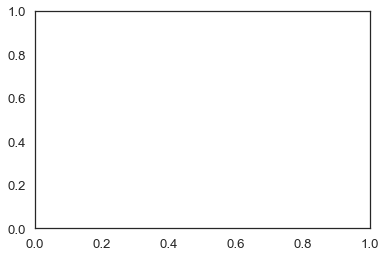

In [47]:
# line plot of k mean values with min/max error bars
plt.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
# plot the ideal case in a separate color
plt.plot(folds, [ideal for _ in range(len(folds))], color='r')
# show the plot
plt.show()

### Random Forest Classifier 

In [68]:
cols = ['Age at OR', 'mean_alpha', 'mean_beta', 'mean_delta',
       'mean_theta', 'mean_gamma', 'mean_rel_alpha', 'mean_rel_power_beta',
       'mean_rel_delta', 'mean_rel_theta', 'mean_rel_gamma', 'delta_alpha',
       'delta_beta', 'delta_theta', 'delta_gamma', 'alpha_beta', 'alpha_theta',
       'alpha_gamma', 'beta_theta', 'beta_gamma', 'theta_gamma']
feature_cols = ['mean_beta', 'mean_delta',
        'mean_gamma',
        'delta_gamma',
        'beta_gamma']
X = annotated_df[feature_cols]
y = annotated_df.BS
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.34)
print(X.shape)
print(y.shape)

(135, 5)
(135,)


### Random Forest Classifier 

In [73]:

random_forest_clf = RandomForestClassifier(max_depth = 32, n_estimators=100)
random_forest_clf.fit(X_train, y_train)
y_pred = random_forest_clf.predict(X_test)


In [74]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6521739130434783


No handles with labels found to put in legend.


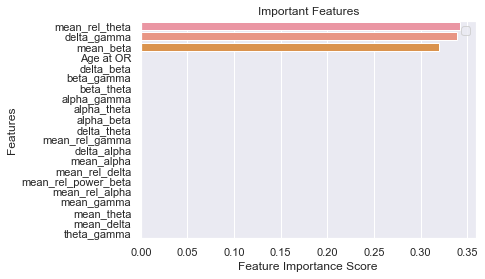

In [75]:
feature_imp = pd.Series(clf.feature_importances_,index=cols).sort_values(ascending=False)
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Important Features")
plt.legend()
plt.show()

In [72]:
rfc = RandomForestClassifier()
parameters = {
    "n_estimators":[5,10,50,100,250],
    "max_depth":[2,4,8,16,32,None]
}
from sklearn.model_selection import GridSearchCV

cv = GridSearchCV(rfc,parameters,cv=5)
cv.fit(X,y.ravel())

def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

display(cv)

Best parameters are: {'max_depth': 32, 'n_estimators': 10}


0.674 + or -0.049 for the {'max_depth': 2, 'n_estimators': 5}
0.696 + or -0.036 for the {'max_depth': 2, 'n_estimators': 10}
0.704 + or -0.041 for the {'max_depth': 2, 'n_estimators': 50}
0.704 + or -0.041 for the {'max_depth': 2, 'n_estimators': 100}
0.704 + or -0.041 for the {'max_depth': 2, 'n_estimators': 250}
0.704 + or -0.041 for the {'max_depth': 4, 'n_estimators': 5}
0.689 + or -0.05 for the {'max_depth': 4, 'n_estimators': 10}
0.681 + or -0.05 for the {'max_depth': 4, 'n_estimators': 50}
0.674 + or -0.043 for the {'max_depth': 4, 'n_estimators': 100}
0.696 + or -0.043 for the {'max_depth': 4, 'n_estimators': 250}
0.652 + or -0.083 for the {'max_depth': 8, 'n_estimators': 5}
0.667 + or -0.062 for the {'max_depth': 8, 'n_estimators': 10}
0.674 + or -0.064 for the {'max_depth': 8, 'n_estimators': 50}
0.652 + or -0.08 for the {'max_depth': 8, 'n_estimators': 100}
0.659 + or -0.092 for the {'max_depth': 8, 'n_estimators':